## Parallel Quantum Amplitude Estimation

The functions in this notebook are based on the following paper:

[Error Resilient Quantum Amplitude Estimation from Parallel Quantum Phase Estimation](https://arxiv.org/abs/2204.01337)

We run a standard serial Quantum Amplitude Estimation (QAE) with two different initializations in order to show the effect of the approximation of the eigenstates. Furthermore, we compare the result of a standard QAE and a parallel implementation. Finally, we draw the circuits for three different implementations of QAE with a precision of two qubits.

In [4]:
import pygrnd
from pygrnd.qc.parallelQAE import *

from qiskit.visualization import plot_histogram
import matplotlib as mpl
from matplotlib import style
mpl.style.use('seaborn')

#### Definition of a model
- This quantum circuit corresponds to a risk model, see e.g. [A Quantum Algorithm for the Sensitivity Analysis of Business Risks](https://arxiv.org/abs/2103.05475)
- We want to find the probabilities of certain results by QAE.

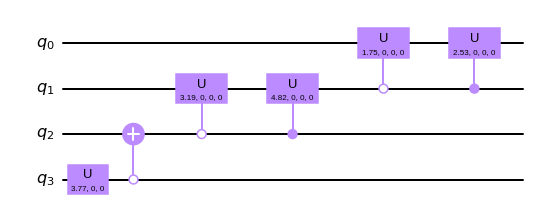

In [2]:
#
# A simple example on 4 qubits.
#

p0=3.765510036975144
p1=3.1948146171818914
p2=4.824329716208535
p3=1.7459012356232146
p4=2.527885232509252

qr=QuantumRegister(4,'q')
qc=QuantumCircuit(qr)
qc.u(p0,0,0,qr[3])
qc.append(XGate().control(ctrl_state='0'),[qr[3],qr[2]])
qc.append(UGate(p1,0,0).control(ctrl_state='0'),[qr[2],qr[1]])
qc.append(UGate(p2,0,0).control(ctrl_state='1'),[qr[2],qr[1]])
qc.append(UGate(p3,0,0).control(ctrl_state='0'),[qr[1],qr[0]])
qc.append(UGate(p4,0,0).control(ctrl_state='1'),[qr[1],qr[0]])
modelGate=qc.to_gate()
modelGate.label="model"
qc.draw(output='mpl')

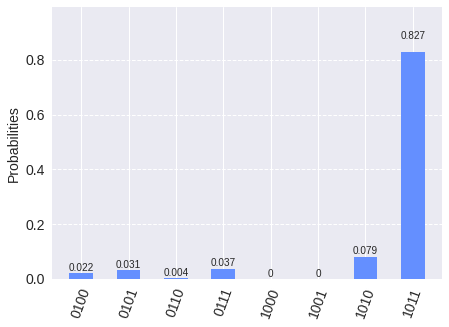

In [4]:
#
# Plot the probabilities of the results. This is just for the visualization of
# the properties of the model circuit.
#

qr=QuantumRegister(4,'q')
cr=ClassicalRegister(4,'c')
qc=QuantumCircuit(qr,cr)
qc.append(modelGate,qr)
qc.measure(qr,cr)

backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend,shots=10000)
result=job.result()
plot_histogram(result.get_counts())

#### Standard QAE - exact eigenvectors vs. eigenstate approximation
- Compare standard QAE with two different initializations for an output precision of $6$ bit
- We consider the good state '1010', the result should be close to 0.08
- Case 1: Use the model as initialization; this leads to a superposition of two eigenvectors.
- Case 2: Use the approximation of one eigenvector

In [5]:
goodState='1010'

# Construct the Grover operator for the model from above.
grover=constructGroverOperator(modelGate, [goodState])

# Construct the standard version of QAE.
qcStandard=circuitStandardQAE(modelGate, grover, 6)

# Construct the approximation of one eigenvector of the Grover operator.
ep=generateStateApproximation(modelGate, goodState)

# Construct the standard version of QAE, where the initialization is replaced by the approximation.
qcApprox=circuitStandardQAE(ep, grover, 6)

In [6]:
#
# Run simulations for both circuits.
#

backend = Aer.get_backend('qasm_simulator')

job = execute(qcStandard, backend,shots=10000)
countsStandard=job.result().get_counts()

job = execute(qcApprox, backend,shots=10000)
countsApprox=job.result().get_counts()

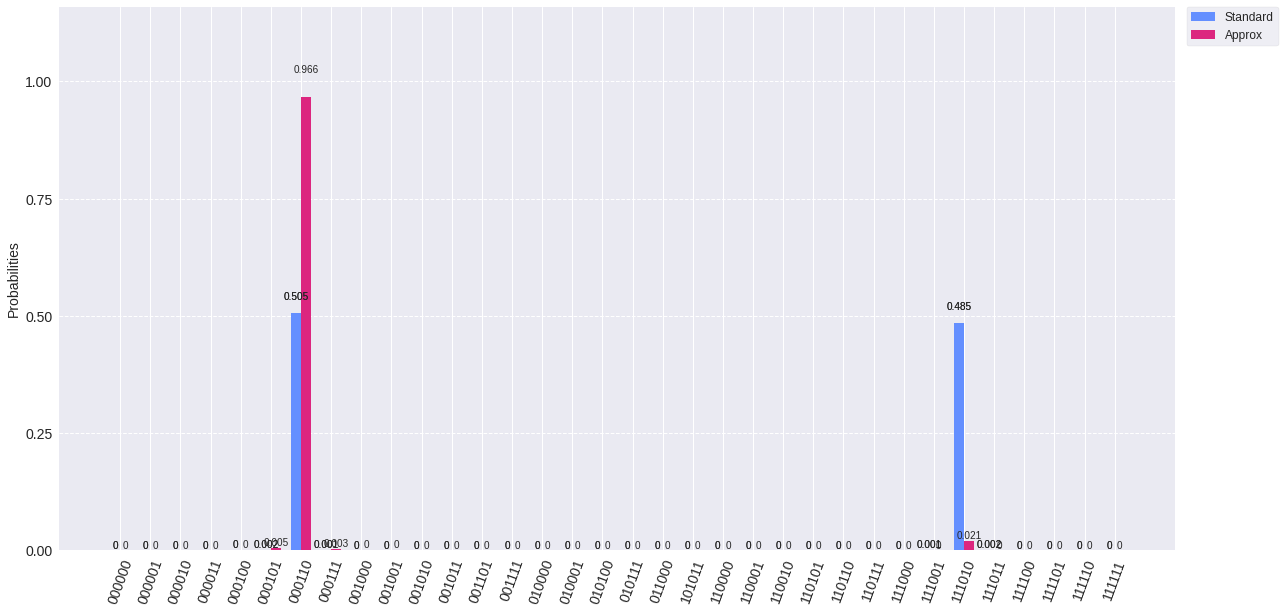

In [7]:
#
# We see that the standard version of QAE uses a uniform superposition of two eigenvectors and this 
# leads to two results, which are equivalent.
#
# In contrast to this, the approximation of the eigenvector leads to just one of the two results.
#

plot_histogram([countsStandard,countsApprox],legend=['Standard','Approx'],figsize=(20,10))

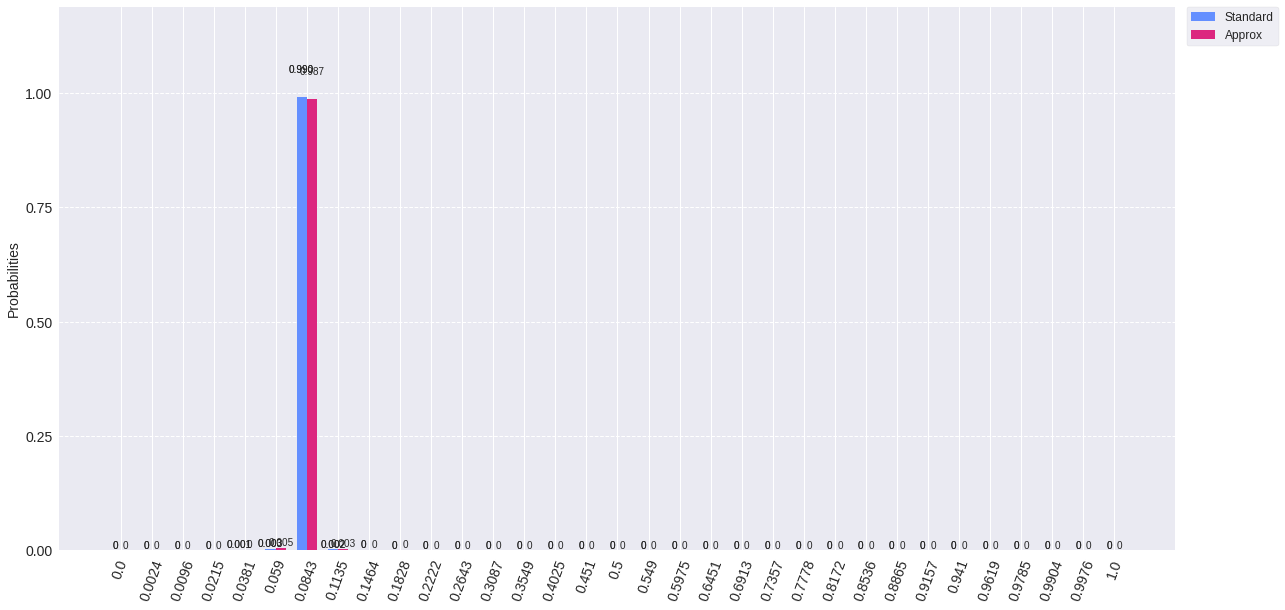

In [8]:
#
# We can map the binary strings of the measured results to the corresponding probability
# values. We also add up the probabilities of equivalent results.
#

probsStandard=getHistogramProbabilityValues(countsStandard)
probsApprox=getHistogramProbabilityValues(countsApprox)
plot_histogram([probsStandard,probsApprox],legend=['Standard','Approx'],figsize=(20,10))

#### Standard QAE vs. parallel QAE with intermediate resets
- We compare the standard version of QAE with standard initialization with the parallel QAE with an approximation of an eigenstate. 
- We consider the good state '1010'.
- In order to make simulations possible, we use the version with intermediate resets of the quantum register.

In [9]:
goodState='1010'

# Construct the Grover operator for the model from above.
grover=constructGroverOperator(modelGate, [goodState])

# Construct the standard version of QAE.
qcStandard=circuitStandardQAE(modelGate, grover, 6)

# Construct the approximation of one eigenvector of the Grover operator.
ep=generateStateApproximation(modelGate, goodState)

# Parallel QAE with an approximation of an eigenvector.
qcParallel=circuitStandardParallelQAEwithResets(ep, grover, 6)

In [10]:
#
# Run simulations for both circuits.
#

backend = Aer.get_backend('qasm_simulator')

job = execute(qcStandard, backend, shots=10000)
countsStandard=job.result().get_counts()

job = execute(qcParallel, backend, shots=10000)
countsParallel=job.result().get_counts()

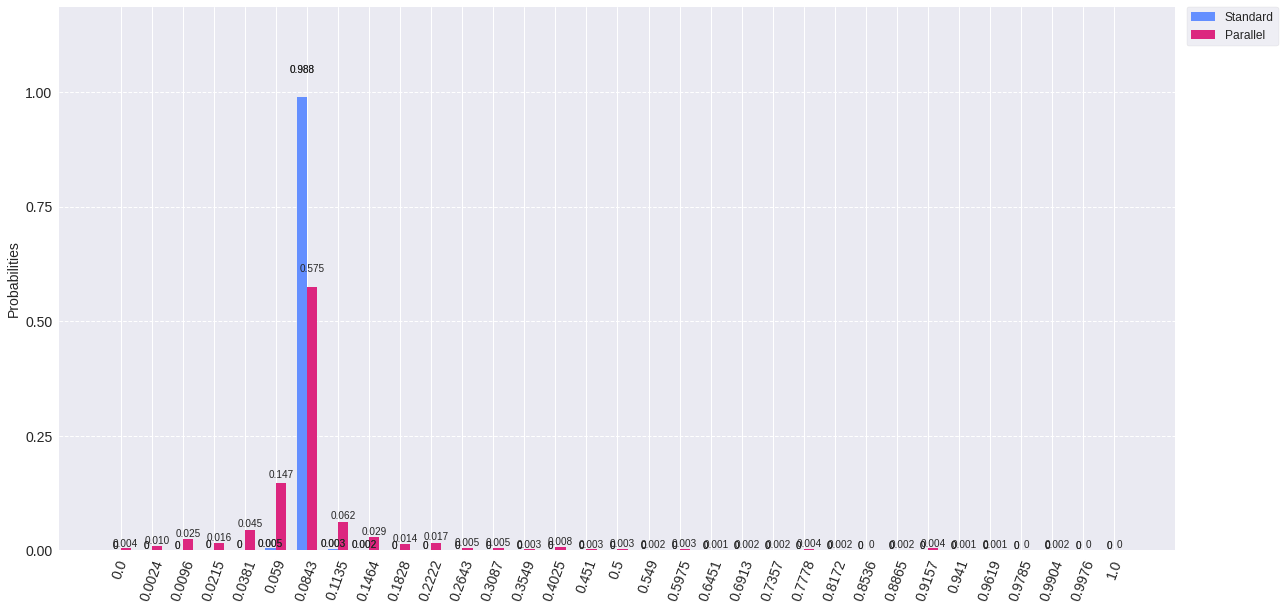

In [11]:
#
# The binary results of QAE are mapped to the corresponding probability values. 
# We see that the approximation of the eigenvector leads to a lower fidelity
# compared to the standard version of QAE, which cannot be run in parallel.
#

probsStandard=getHistogramProbabilityValues(countsStandard)
probsParallel=getHistogramProbabilityValues(countsParallel)
plot_histogram([probsStandard,probsParallel],legend=['Standard','Parallel'],figsize=(20,10))

#### Comparison of circuit structures
- We plot the circuits for a precision of $2$ bits for three different cases
- (1) Standard QAE
- (2) Parallel QAE with approximation of eigenvector
- (3) Parallel QAE with approximation of eigenvector and intermediate resets

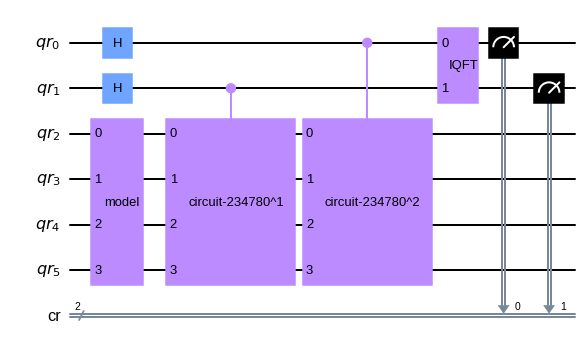

In [12]:
#
# The standard QAE.
#

goodState='1010'

# Construct the Grover operator for the model from above.
grover=constructGroverOperator(modelGate, [goodState])

# Construct the standard version of QAE.
qcStandard=circuitStandardQAE(modelGate, grover, 2)

qcStandard.draw(output='mpl')

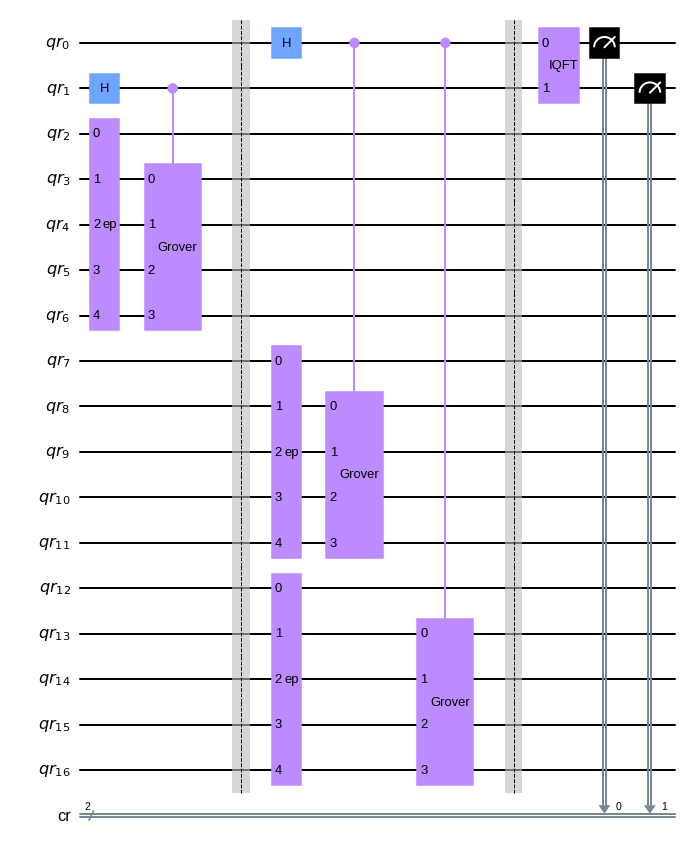

In [13]:
#
# The parallel QAE with an approximation of an eigenvector.
#

goodState='1010'

# Construct the Grover operator for the model from above.
grover=constructGroverOperator(modelGate, [goodState])

# Construct the approximation of one eigenvector of the Grover operator.
ep=generateStateApproximation(modelGate, goodState)

# Parallel QAE with an approximation of an eigenvector.
qcParallel=circuitStandardParallelQAE(ep, grover, 2)

qcParallel.draw(output='mpl')

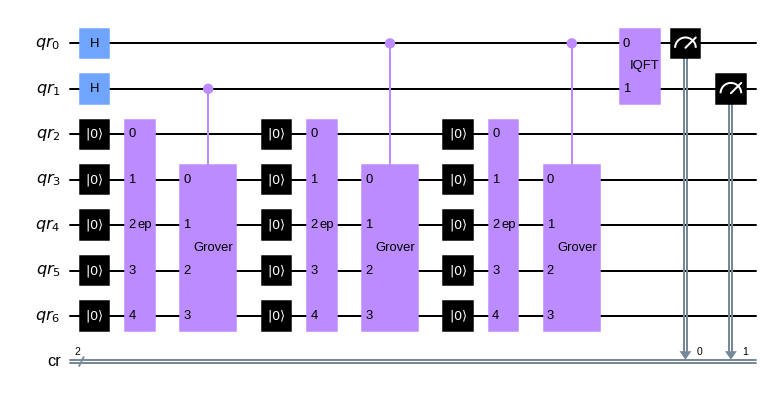

In [14]:
#
# The parallel QAE with an approximation of an eigenvector and intermediate resets.
#

goodState='1010'

# Construct the Grover operator for the model from above.
grover=constructGroverOperator(modelGate, [goodState])

# Construct the approximation of one eigenvector of the Grover operator.
ep=generateStateApproximation(modelGate, goodState)

# Parallel QAE with an approximation of an eigenvector with intermediate resets.
qcParallelResets=circuitStandardParallelQAEwithResets(ep, grover, 2)

qcParallelResets.draw(output='mpl')

## Testing with different risk model built with pygrnd function

In [1]:
from pygrnd.qc.helper import *
from pygrnd.qc.brm import *
from pygrnd.qc.brm_oracle import *
from pygrnd.qc.QAE import *

In [71]:
## small example

RI1=0.8
RI2=0.2
RI3=0.1
RI4=0.05
T23=0.2
T24=0.1

nodes=['0','1','2','3'] # risk items defition
edges=[('1','2'),('1','3')] # correlations

probsNodes={'0':RI1,'1':RI2,'2':RI3,'3':RI4} # intrinsic probs
probsEdges={('1','2'):T23,('1','3'):T24} # transition probs

print("Number of risk items = ",len(nodes))
print("Number of correlations = ",len(edges))

rm, mat = brm(nodes, edges, probsNodes, probsEdges, model2gate=True)
#rm.draw(output='mpl')

Number of risk items =  4
Number of correlations =  2


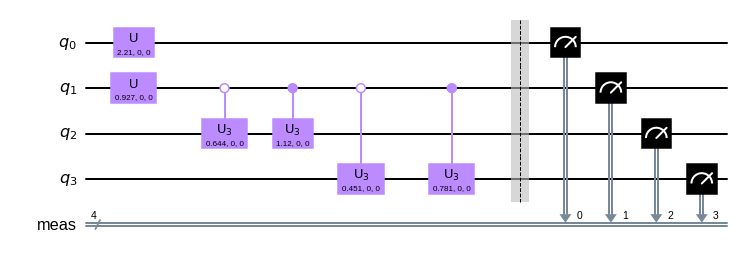

-------------------------------


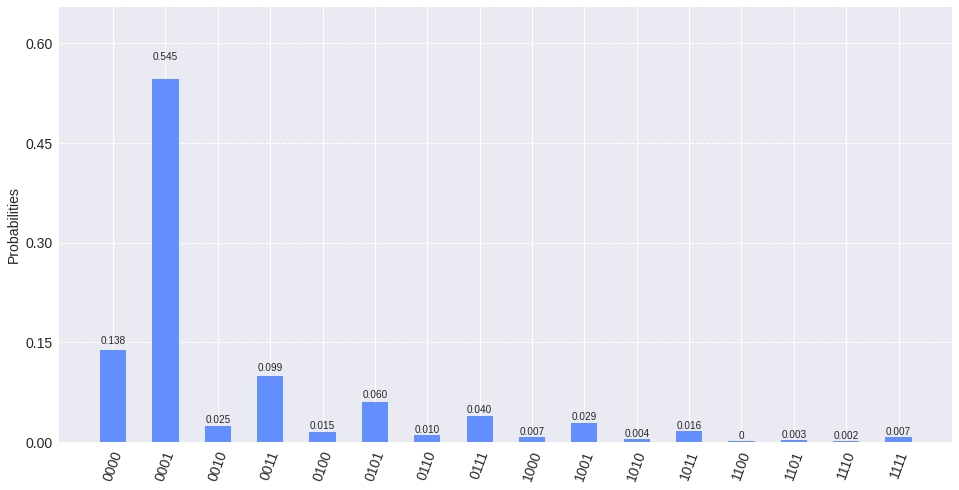

In [70]:
rm.measure_all()
display(rm.draw(output='mpl'))
print("-------------------------------")

backend = Aer.get_backend('qasm_simulator')
job = execute(rm, backend,shots=100000)
#result=job.result()
counts=job.result().get_counts()
plot_histogram(counts,figsize=(16,8))

## Serial QAE

In [72]:
goodState='1111'

# Construct the Grover operator for the model from above.
grover=constructGroverOperator(rm, [goodState])

# Construct the standard version of QAE.
qcStandard=circuitStandardQAE(rm, grover, 6)

# Construct the approximation of one eigenvector of the Grover operator.
ep=generateStateApproximation(rm, goodState)

# Construct the standard version of QAE, where the initialization is replaced by the approximation.
qcApprox=circuitStandardQAE(ep, grover, 6)

In [73]:
#
# Run simulations for both circuits.
#

backend = Aer.get_backend('qasm_simulator')

job = execute(qcStandard, backend,shots=10000)
countsStandard=job.result().get_counts()

job = execute(qcApprox, backend,shots=10000)
countsApprox=job.result().get_counts()

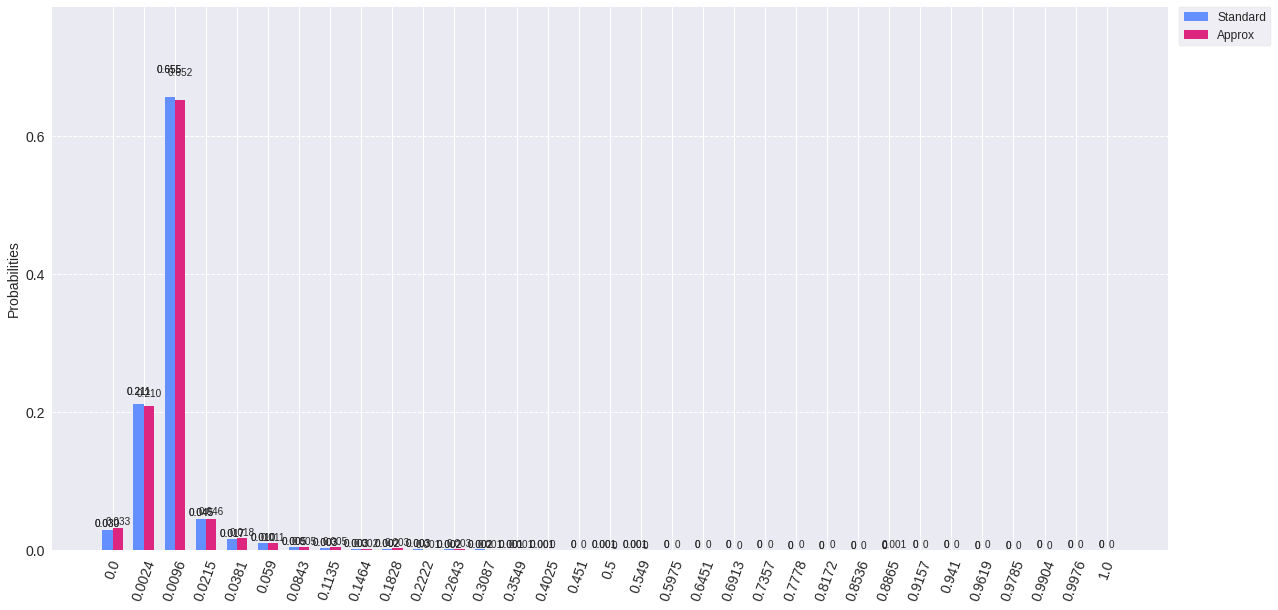

In [74]:
#
# We can map the binary strings of the measured results to the corresponding probability
# values. We also add up the probabilities of equivalent results.
#

probsStandard=getHistogramProbabilityValues(countsStandard)
probsApprox=getHistogramProbabilityValues(countsApprox)
plot_histogram([probsStandard,probsApprox],legend=['Standard','Approx'],figsize=(20,10))

In [75]:
probsStandard

{0.0: 0.0296,
 0.0024: 0.21139999999999998,
 0.0096: 0.6553,
 0.0215: 0.045,
 0.0381: 0.0167,
 0.059: 0.0103,
 0.0843: 0.0053,
 0.1135: 0.0034000000000000002,
 0.1464: 0.0025,
 0.1828: 0.0018999999999999998,
 0.2222: 0.0026,
 0.2643: 0.0015999999999999999,
 0.3087: 0.0015,
 0.3549: 0.0013,
 0.4025: 0.0013,
 0.451: 0.0009,
 0.5: 0.0013,
 0.549: 0.0012000000000000001,
 0.5975: 0.0005,
 0.6451: 0.0006000000000000001,
 0.6913: 0.0005,
 0.7357: 0.0005,
 0.7778: 0.0002,
 0.8172: 0.0003,
 0.8536: 0.00039999999999999996,
 0.8865: 0.0002,
 0.9157: 0.0005,
 0.941: 0.0007,
 0.9619: 0.00039999999999999996,
 0.9785: 0.0004,
 0.9904: 0.0005,
 0.9976: 0.0007,
 1.0: 0.0005}

## parallel QAE

In [82]:
goodState='1111'

# Construct the Grover operator for the model from above.
grover=constructGroverOperator(rm, [goodState])

# Construct the standard version of QAE.
qcStandard=circuitStandardQAE(rm, grover, 7)

# Construct the approximation of one eigenvector of the Grover operator.
ep=generateStateApproximation(rm, goodState)

# Parallel QAE with an approximation of an eigenvector.
qcParallel=circuitStandardParallelQAEwithResets(ep, grover, 7)

In [83]:
#
# Run simulations for both circuits.
#

backend = Aer.get_backend('qasm_simulator')

job = execute(qcStandard, backend, shots=10000)
countsStandard=job.result().get_counts()

job = execute(qcParallel, backend, shots=10000)
countsParallel=job.result().get_counts()

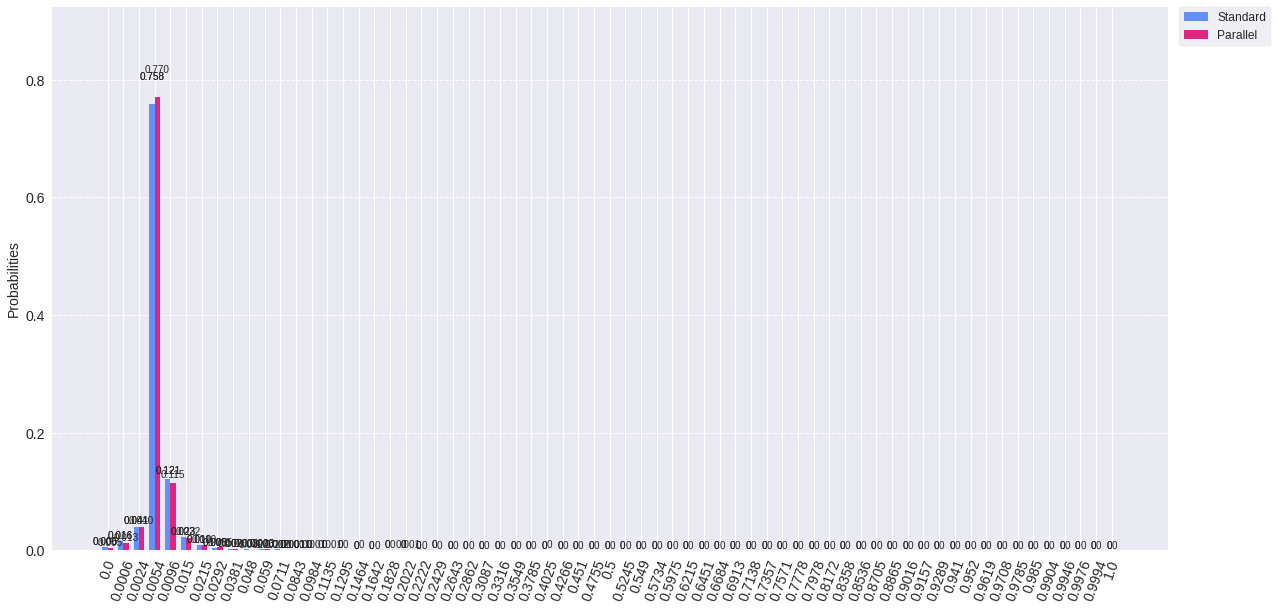

In [84]:
#
# The binary results of QAE are mapped to the corresponding probability values. 
# We see that the approximation of the eigenvector leads to a lower fidelity
# compared to the standard version of QAE, which cannot be run in parallel.
#

probsStandard=getHistogramProbabilityValues(countsStandard)
probsParallel=getHistogramProbabilityValues(countsParallel)
plot_histogram([probsStandard,probsParallel],legend=['Standard','Parallel'],figsize=(20,10))